In [ ]:
import json
import os
from sklearn.metrics import roc_curve, auc
import numpy as np
import datasets

# Base directory template for the data files
base_dir_template = '~/maplecg_nfs_public/watermark_arxiv/main_results/seed_{}/calibration/'
wtm_base_dir_template = '~/maplecg_nfs_public/watermark_arxiv/main_results/seed_{}/watermarked_calibration/'

# Seeds to process
seeds = [41, 42, 43]

# Function to compute AUC for specified paths
def compute_auc(forget_file_path, retain_file_path, key):
    with open(forget_file_path, 'r') as file:
        forget_data = json.load(file)
    forget_values = [item[key] for item in forget_data] if isinstance(forget_data, list) else list(forget_data[key].values())

    with open(retain_file_path, 'r') as file:
        retain_data = json.load(file)
    retain_values = [item[key] for item in retain_data] if isinstance(retain_data, list) else list(retain_data[key].values())

    labels = [0] * len(forget_values) + [1] * len(retain_values)
    scores = forget_values + retain_values
    fpr, tpr, _ = roc_curve(labels, scores)
    return auc(fpr, tpr)


rouge_aucs = []
knowmem_aucs = []
wtm_aucs = []

for seed in seeds:
    base_dir = base_dir_template.format(seed)
    wtm_base_dir = wtm_base_dir_template.format(seed)   
    
    # For ROUGE
    rouge_roc_auc = compute_auc(
        os.path.join(base_dir, 'eval/retraining/10pct_eval_rouge_forget.json'),
        os.path.join(base_dir, 'eval/retraining/10pct_eval_rouge.json'),
        'rougeL_recall'
    )
    rouge_aucs.append(rouge_roc_auc)

    # For KnowMem
    knowmem_roc_auc = compute_auc(
        os.path.join(base_dir, f'eval/knowmem/10/retraining/eval_knowmem_forget.json'),
        os.path.join(base_dir, f'eval/knowmem/10/retraining/eval_knowmem_retain.json'),
        "rougeL_recall"
    )
    knowmem_aucs.append(knowmem_roc_auc)
    
    # For WTM
    wtm_path = os.path.join(wtm_base_dir, f'watermark_verify/retraining_10pct_verify_0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_17_18_19_1_0')
    q = np.array(datasets.load_from_disk(wtm_path)["q"]) 
    retain_values = list(q[:8000,:,:].reshape(-1,400,10,20).diagonal(axis1=0,axis2=3)[...,:-1].flatten())
    forget_values = list(q[:8000,:,:].reshape(-1,400,10,20).diagonal(axis1=0,axis2=3)[...,-1].flatten())   
    labels = [0] * len(forget_values) + [1] * len(retain_values)
    scores = forget_values + retain_values
    fpr, tpr, _ = roc_curve(labels, scores)
    wtm_aucs.append(auc(fpr, tpr))

# Calculate mean and standard deviation
rouge_mean = np.mean(rouge_aucs)
rouge_std = np.std(rouge_aucs)
knowmem_mean = np.mean(knowmem_aucs)
knowmem_std = np.std(knowmem_aucs)
wtm_mean = np.mean(wtm_aucs)
wtm_std = np.std(wtm_aucs)

# Print results
print(f"\nResults for calibration:")
print("Metric\t\tMean AUC\tStd AUC")
print(f"ROUGE\t\t{rouge_mean:.4f}\t\t{rouge_std:.4f}")
print(f"KnowMem\t\t{knowmem_mean:.4f}\t\t{knowmem_std:.4f}")
print(f"WTM\t\t{wtm_mean:.4f}\t\t{wtm_std:.4f}")

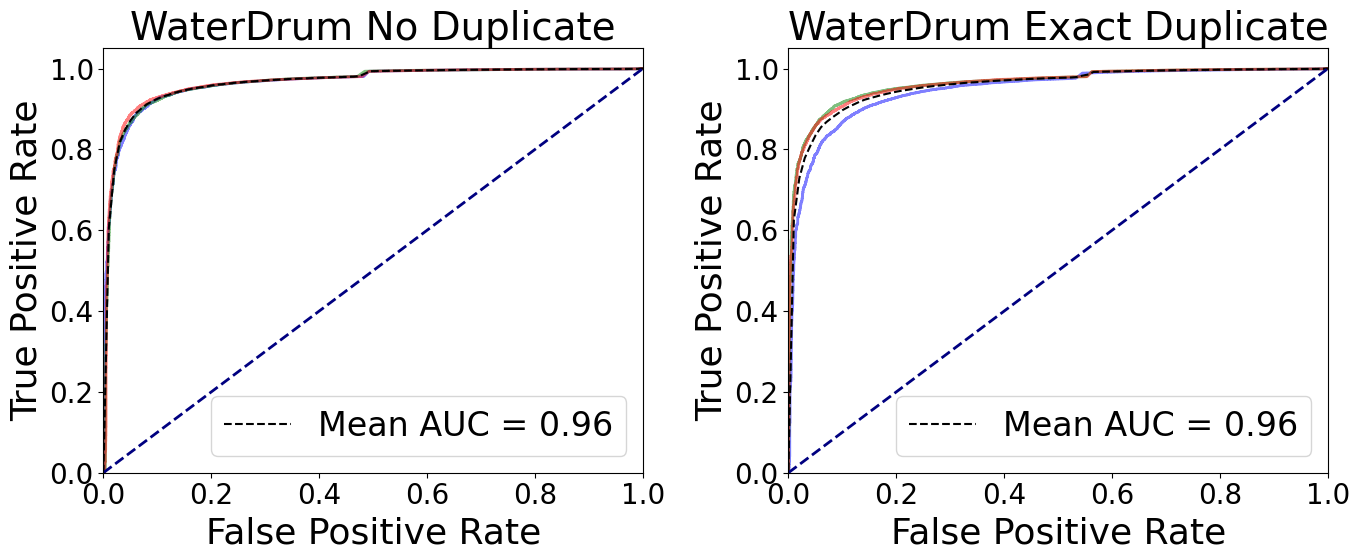

In [8]:
import json
import os
from sklearn.metrics import roc_curve, auc
import numpy as np
import datasets
import matplotlib.pyplot as plt

# Base directory templates for the data files
wtm_base_dir_template_dup = '/home/xinyang/maplecg_nfs_public/watermark_arxiv/main_results/seed_{}/watermarked_calibration_duplicate/'
wtm_base_dir_template_ori = '/home/xinyang/maplecg_nfs_public/watermark_arxiv/main_results/seed_{}/watermarked_calibration/'

# Seeds to process
seeds = [41, 42, 43]

# Function to compute AUC and return points for curve
def compute_fpr_tpr_auc(forget_file_path, retain_file_path, key):
    with open(forget_file_path, 'r') as file:
        forget_data = json.load(file)
    forget_values = [item[key] for item in forget_data] if isinstance(forget_data, list) else list(forget_data[key].values())

    with open(retain_file_path, 'r') as file:
        retain_data = json.load(file)
    retain_values = [item[key] for item in retain_data] if isinstance(retain_data, list) else list(retain_data[key].values())

    labels = [0] * len(forget_values) + [1] * len(retain_values)
    scores = forget_values + retain_values
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

# Arrays to store AUCs and FPRs/TPRs for both datasets
wtm_aucs_dup = []
wtm_aucs_ori = []
wtm_fpr_tpr_dup = []
wtm_fpr_tpr_ori = []

# Process each seed for both datasets
for seed in seeds:
    for base_dir_template, aucs, fpr_tpr in [
        (wtm_base_dir_template_ori, wtm_aucs_ori, wtm_fpr_tpr_ori),
        (wtm_base_dir_template_dup, wtm_aucs_dup, wtm_fpr_tpr_dup)
    ]:
        wtm_base_dir = base_dir_template.format(seed)

        # For WaterDrum
        wtm_path = os.path.join(wtm_base_dir, 'watermark_verify/retraining_10pct_verify_0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_17_18_19_1_0')
        q = np.array(datasets.load_from_disk(wtm_path)["q"]) 
        retain_values = list(q[:8000,:,:].reshape(-1,400,10,20).diagonal(axis1=0,axis2=3)[...,:-1].flatten())
        forget_values = list(q[:8000,:,:].reshape(-1,400,10,20).diagonal(axis1=0,axis2=3)[...,-1].flatten())   
        labels = [0] * len(forget_values) + [1] * len(retain_values)
        scores = forget_values + retain_values
        fpr, tpr, _ = roc_curve(labels, scores)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        fpr_tpr.append((fpr, tpr))

plt.rcParams.update({'font.size': 20})
# Adjusted Plotting for Two Columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
metric_names = ["WaterDrum No Duplicate", "WaterDrum Exact Duplicate"]
fpr_tpr_datas = [wtm_fpr_tpr_ori, wtm_fpr_tpr_dup]
aucs_list = [wtm_aucs_ori, wtm_aucs_dup]

for j, (ax, metric_name, auroc_fpr_tpr, aucs) in enumerate(zip(axes, metric_names, fpr_tpr_datas, aucs_list)):
    for i, (fpr, tpr) in enumerate(auroc_fpr_tpr):
        ax.plot(fpr, tpr, lw=2, alpha=0.5, color=colors[i])

    # Calculate and plot mean ROC
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in auroc_fpr_tpr], axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    ax.plot(mean_fpr, mean_tpr, color='black', linestyle='--', label=f'Mean AUC = {mean_auc:.2f}')

    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=26)
    ax.set_ylabel('True Positive Rate', fontsize=26)
    ax.set_title(f'{metric_name}', fontsize=28)
    ax.legend(loc="lower right", fontsize=24)

plt.tight_layout()
plt.show()